# Model building

This notebook is organized as follows.

-------
## CONTENTS

1. [Data loading](#load)

2. [Data preparation](#prep)

3. [Clustering with k-means](#kmeans)

4. [Principal component analysis](#pca)
--------


In [1]:
# importing libraries
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

sys.path.append("../src/")
from tools import *
from utility import *

## 1. Data loading <a name="load"></a>

In [2]:
df1 = pd.read_csv("../data/data_added_prescriptions.csv")

## 2. Data preparation <a name="prep"></a>

In [3]:
# if approach 1 is used:

df = df1.copy()

# create a list of suffix
suffix_list = [
    "conference_total",
    "email_open_total",
    "f2f_total",
    "webinar_total",
]

# only keep columns 3, 6, 9 and 12 with the same suffix
# drop all other columns since they have overlaping information and highly correlated
for each_suffix in suffix_list:
    df = drop_selected_cols(data_frame=df, suffix=each_suffix, sep="_")

In [4]:
# remove columns with all values equal to zero
df.drop(["f2f_total_12"], inplace=True, axis=1)
df.drop(["webinar_total_12"], inplace=True, axis=1)

In [5]:
df.head()

,rep_id,conference_total_03,conference_total_06,conference_total_09,conference_total_12,email_open_total_03,email_open_total_06,email_open_total_09,email_open_total_12,f2f_total_03,...,webinar_total_06,webinar_total_09,is_cardiologist,is_gp,years_since_graduation,gender_female,gender_male,hospital,office,prescription_total
0,100,0,0,1,0,1,0,0,1,4,...,2,1,0,1,23,1.0,0.0,0.0,1.0,3
1,101,0,0,1,0,0,0,2,1,0,...,0,0,0,1,27,0.0,1.0,0.0,1.0,2
2,101,0,0,0,0,0,1,1,0,1,...,0,1,0,1,29,0.0,1.0,1.0,0.0,83
3,102,0,0,0,0,0,0,1,0,0,...,0,0,0,1,22,1.0,0.0,1.0,0.0,2
4,103,0,0,0,1,0,2,1,2,3,...,0,0,0,1,27,0.0,1.0,0.0,1.0,4


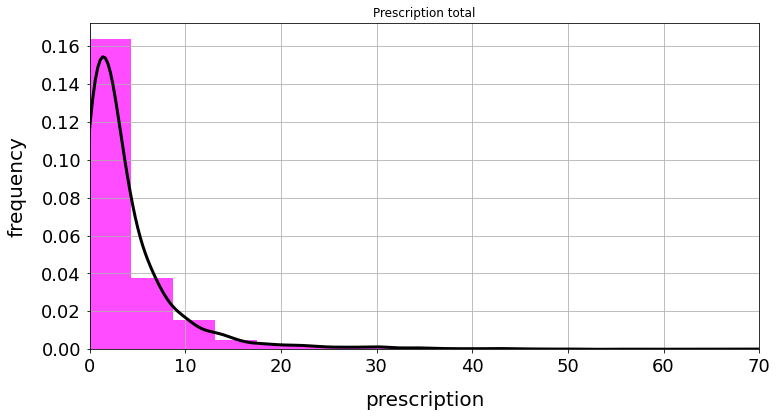

In [6]:
# distribution of prescription
fig, ax = plt.subplots(figsize=(12, 6))

presc = df["prescription_total"]
presc.plot.kde(
    ax=ax,
    legend=False,
    title="Prescription total",
    color="k",
    linewidth=3,
)
presc.plot.hist(density=True, bins=30, ax=ax, fontsize=14, alpha=0.7, color="fuchsia")
ax.set_ylabel("frequency", size=20, labelpad=15)
ax.set_xlabel("prescription", size=20, labelpad=15)

plt.xlim([0, 70])
plt.grid()
plt.tick_params(axis="both", labelsize=18, pad=5)

plt.show()
plt.close()

## 3. Clustering with k-means <a name="kmeans"></a>

In [7]:
# apply min-max normalization
normalized_df = (df - df.min()) / (df.max() - df.min())
normalized_df.head()

,rep_id,conference_total_03,conference_total_06,conference_total_09,conference_total_12,email_open_total_03,email_open_total_06,email_open_total_09,email_open_total_12,f2f_total_03,...,webinar_total_06,webinar_total_09,is_cardiologist,is_gp,years_since_graduation,gender_female,gender_male,hospital,office,prescription_total
0,0.000000,0.0,0.0,0.333333,0.000000,0.142857,0.000000,0.000000,0.166667,0.190476,...,0.222222,0.333333,0.0,1.0,0.307692,1.0,0.0,0.0,1.0,0.022901
1,0.006579,0.0,0.0,0.333333,0.000000,0.000000,0.000000,0.285714,0.166667,0.000000,...,0.000000,0.000000,0.0,1.0,0.369231,0.0,1.0,0.0,1.0,0.015267
2,0.006579,0.0,0.0,0.000000,0.000000,0.000000,0.166667,0.142857,0.000000,0.047619,...,0.000000,0.333333,0.0,1.0,0.400000,0.0,1.0,1.0,0.0,0.633588
3,0.013158,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,...,0.000000,0.000000,0.0,1.0,0.292308,1.0,0.0,1.0,0.0,0.015267
4,0.019737,0.0,0.0,0.000000,0.333333,0.000000,0.333333,0.142857,0.333333,0.142857,...,0.000000,0.000000,0.0,1.0,0.369231,0.0,1.0,0.0,1.0,0.030534


In [8]:
df_features = normalized_df.copy()
# create a new dataset without the target variable
# features = normalized_df.columns[:-2]
# df_features = normalized_df[features]
df_features.head()

,rep_id,conference_total_03,conference_total_06,conference_total_09,conference_total_12,email_open_total_03,email_open_total_06,email_open_total_09,email_open_total_12,f2f_total_03,...,webinar_total_06,webinar_total_09,is_cardiologist,is_gp,years_since_graduation,gender_female,gender_male,hospital,office,prescription_total
0,0.000000,0.0,0.0,0.333333,0.000000,0.142857,0.000000,0.000000,0.166667,0.190476,...,0.222222,0.333333,0.0,1.0,0.307692,1.0,0.0,0.0,1.0,0.022901
1,0.006579,0.0,0.0,0.333333,0.000000,0.000000,0.000000,0.285714,0.166667,0.000000,...,0.000000,0.000000,0.0,1.0,0.369231,0.0,1.0,0.0,1.0,0.015267
2,0.006579,0.0,0.0,0.000000,0.000000,0.000000,0.166667,0.142857,0.000000,0.047619,...,0.000000,0.333333,0.0,1.0,0.400000,0.0,1.0,1.0,0.0,0.633588
3,0.013158,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,...,0.000000,0.000000,0.0,1.0,0.292308,1.0,0.0,1.0,0.0,0.015267
4,0.019737,0.0,0.0,0.000000,0.333333,0.000000,0.333333,0.142857,0.333333,0.142857,...,0.000000,0.000000,0.0,1.0,0.369231,0.0,1.0,0.0,1.0,0.030534


**Elbow method**

We can use the elbow method to choose the best number of clusters.

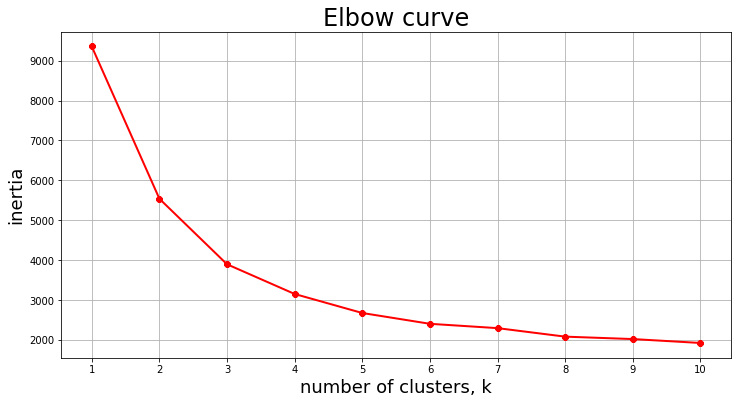

In [9]:
inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    # kmeans.fit(normalized_df.iloc[:, 1:])
    kmeans.fit(df_features.iloc[:, 1:])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.grid()
plt.plot(range(1, 11), inertia, linewidth=2, color="red", marker="8")
plt.xlabel("number of clusters, k", fontdict={"fontsize": 18, "fontweight": "medium"})
plt.ylabel("inertia", fontdict={"fontsize": 18, "fontweight": "medium"})
plt.xticks(np.arange(1, 11, 1))
plt.title("Elbow curve", fontdict={"fontsize": 24, "fontweight": "medium"})
plt.show()

In [10]:
# k means using 4 clusters and k-means++ initialization
kmeans = KMeans(n_clusters=4, init="k-means++")

# fitting the k means algorithm on scaled data
# kmeans.fit(normalized_df)
# pred = kmeans.predict(normalized_df)
pred = kmeans.fit_predict(normalized_df)

# inertia on the fitted data
kmeans.inertia_

3605.145864534909

In [11]:
# add the clusters as a columns into the dataframe
# df_with_clusters = pd.DataFrame(normalized_df)
df_with_clusters = normalized_df.copy()
df_with_clusters["cluster"] = pred

# show how populated the clusters are

df_with_clusters["cluster"].value_counts()

0    4356
1    2453
3    1003
2     531
Name: cluster, dtype: int64

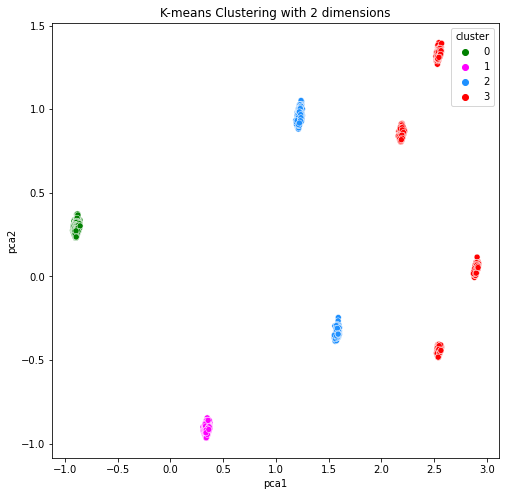

In [12]:
#
kmeans = KMeans(n_clusters=4)
df_features["cluster"] = kmeans.fit_predict(df_features)

reduced_data = PCA(n_components=2).fit_transform(df_features)
results = pd.DataFrame(reduced_data, columns=["pca1", "pca2"])

plt.figure(figsize=(8, 8))
sns.scatterplot(
    x="pca1",
    y="pca2",
    hue=df_features["cluster"],
    data=results,
    palette=["green", "magenta", "dodgerblue", "red"],
)
plt.title("K-means Clustering with 2 dimensions")
plt.show()

----------------

## 4. Principal component analysis <a name="pca"></a>

In [13]:
# pca with all components
pca_all = PCA()
pca_all.fit(df_features)
all_components = pca_all.transform(df_features)
pca_all.explained_variance_ratio_

array([5.80443314e-01, 2.05209517e-01, 6.67101794e-02, 2.35538106e-02,
       1.61237946e-02, 1.32678507e-02, 1.28223678e-02, 1.17681584e-02,
       1.11274114e-02, 1.03718087e-02, 9.42803460e-03, 9.16143305e-03,
       8.22322850e-03, 5.04418342e-03, 4.95837936e-03, 3.31662260e-03,
       2.48480216e-03, 2.26226713e-03, 1.84067329e-03, 9.95107931e-04,
       8.87055305e-04, 1.66928369e-32, 5.34131949e-33, 4.62517143e-34])

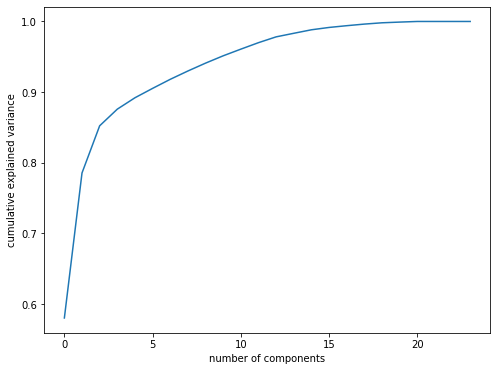

In [14]:
# plot cumulative explained variance ratio as function of the number of components
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")
plt.show()
plt.close()

In [15]:
# pca with 2 components
pca_2 = PCA(n_components=2)
pca_2.fit(df_features)
pca_2comp = pca_2.transform(df_features)
pca1, pca2 = pca_2.explained_variance_ratio_
print(
    f"Two principal components explain {np.round(((pca1+pca2)*100), 1)}% of the variance"
)

Two principal components explain 78.6% of the variance
